# Temporal Analysis

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [2]:
# Plotly template config
pio.templates.default = "plotly_white"

### Loading datasets

In [3]:
df_enrolment = pd.read_parquet('enrolment_cleaned.parquet')
df_demographic = pd.read_parquet('demographic_cleaned.parquet')
df_biometric = pd.read_parquet('biometric_cleaned.parquet')

### Macro Trends: Monthly & Quarterly Analysis
##### To visualize the long-term trajectory.

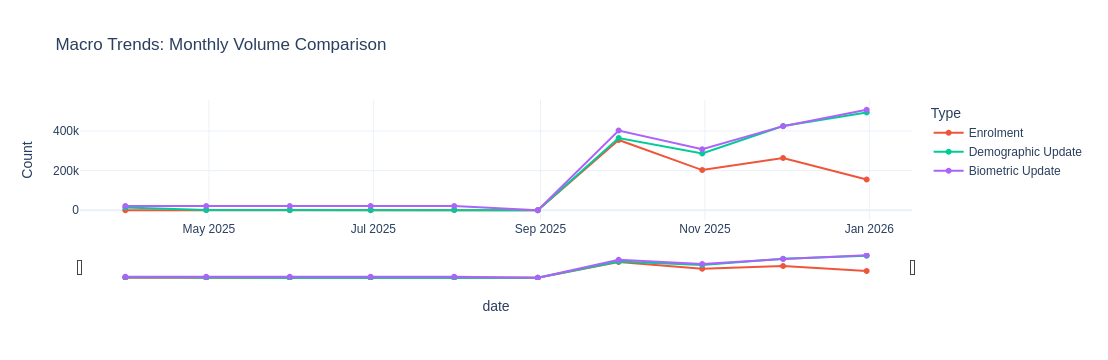

In [4]:
def plot_macro_trends(df_enrol, df_demo, df_bio):
    # 1. Resample to Monthly Frequency
    df_enrol['date'] = pd.to_datetime(df_enrol['date'])
    df_demo['date'] = pd.to_datetime(df_demo['date'])
    df_bio['date'] = pd.to_datetime(df_bio['date'])

    m_enrol = df_enrol.set_index('date').resample('ME').size().reset_index(name='Count')
    m_enrol['Type'] = 'Enrolment'
    
    m_demo = df_demo.set_index('date').resample('ME').size().reset_index(name='Count')
    m_demo['Type'] = 'Demographic Update'
    
    m_bio = df_bio.set_index('date').resample('ME').size().reset_index(name='Count')
    m_bio['Type'] = 'Biometric Update'
    
    # 2. Combine
    combined = pd.concat([m_enrol, m_demo, m_bio])
    
    # 3. Plot
    fig = px.line(
        combined,
        x='date',
        y='Count',
        color='Type',
        title='Macro Trends: Monthly Volume Comparison',
        markers=True,
        color_discrete_sequence=["#EF553B", "#00CC96", "#AB63FA"]
    )
    
    # Add Range Slider for "Zooming"
    fig.update_xaxes(rangeslider_visible=True)
    fig.show()

plot_macro_trends(df_enrolment, df_demographic, df_biometric)

### Day-of-Month Analysis
##### To check if activity spikes on specific days of the month

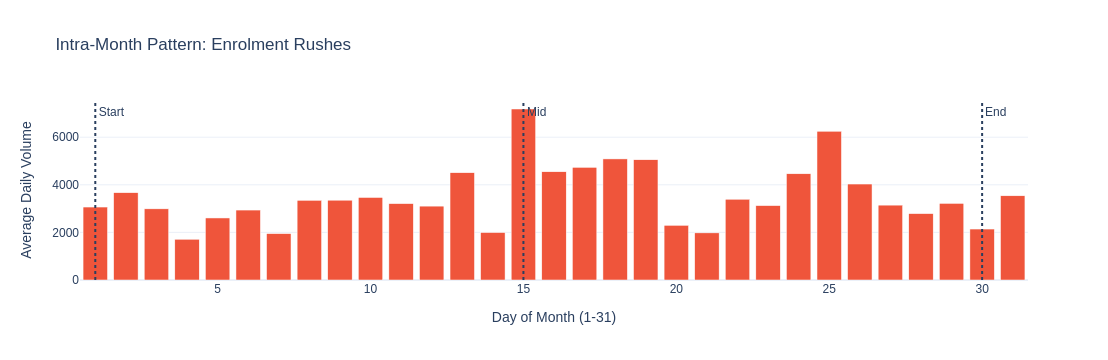

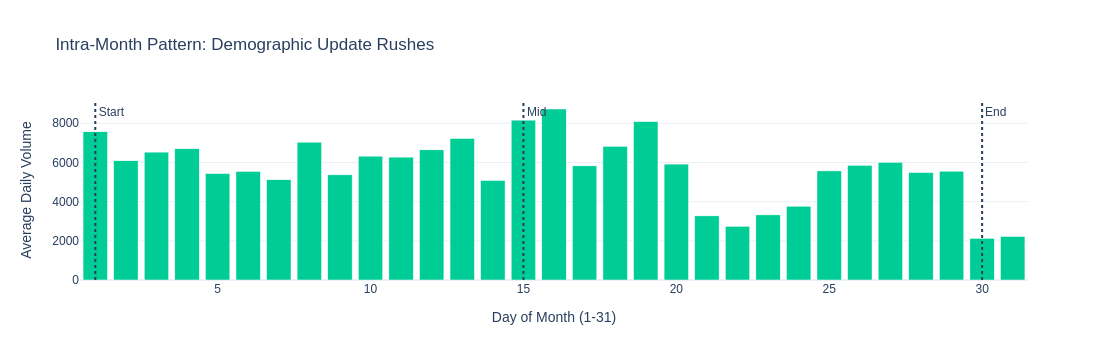

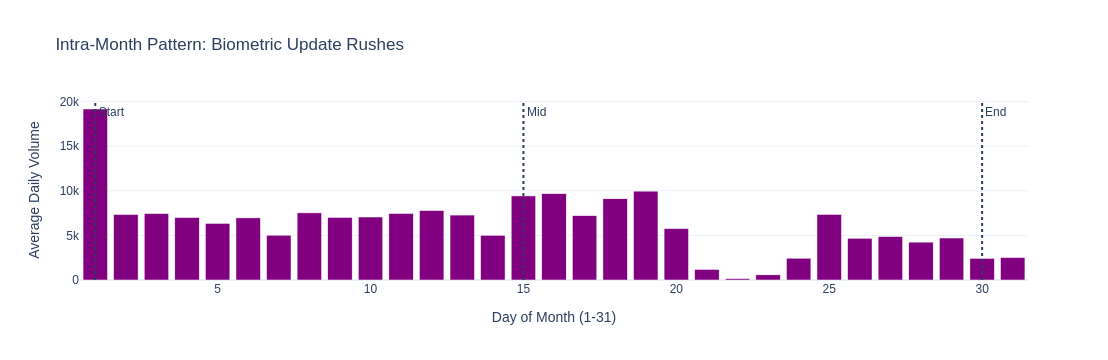

In [7]:
def analyze_day_of_month(df, title, color_hex):
    # Extract Day Number (1-31)
    df['Day_Num'] = df['date'].dt.day
    
    # Calculate Average Volume per Day-Number
    # (Total Volume on Day X / Number of times Day X occurred)
    # Simple approximation: Mean count per day-number
    daily_stats = df.groupby('Day_Num').size().reset_index(name='Total_Volume')
    
    # Normalize by how many months exist in dataset to get "Avg per Day"
    # (Approximation: divide by unique year-months)
    num_months = df['date'].dt.to_period('M').nunique()
    daily_stats['Avg_Volume'] = daily_stats['Total_Volume'] / num_months
    
    fig = px.bar(
        daily_stats,
        x='Day_Num',
        y='Avg_Volume',
        title=f"Intra-Month Pattern: {title}",
        labels={'Day_Num': 'Day of Month (1-31)', 'Avg_Volume': 'Average Daily Volume'},
        color_discrete_sequence=[color_hex]
    )
    
    # Highlight Start/Mid/End
    fig.add_vline(x=1, line_dash="dot", annotation_text="Start")
    fig.add_vline(x=15, line_dash="dot", annotation_text="Mid")
    fig.add_vline(x=30, line_dash="dot", annotation_text="End")
    
    fig.show()

analyze_day_of_month(df_enrolment, "Enrolment Rushes", "#EF553B")
analyze_day_of_month(df_demographic, "Demographic Update Rushes", "#00CC96")
analyze_day_of_month(df_biometric, "Biometric Update Rushes", "purple")

### Holiday & Festival Impact Analysis
##### To visualize how volume behaves around major national holidays.

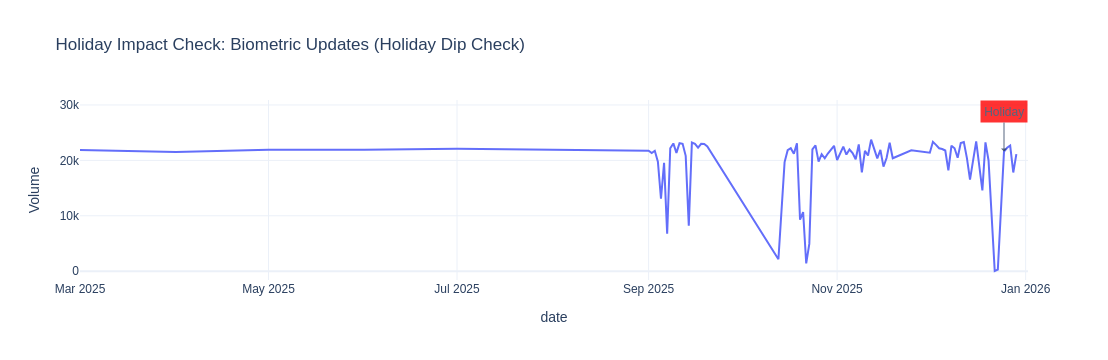

In [9]:
def analyze_holiday_impact(df, title):
    # 1. Aggregate Daily
    daily = df.groupby('date').size().reset_index(name='Volume')
    
    # 2. Define Major Fixed Holidays
    holidays = pd.to_datetime([
        '2024-01-26', '2025-01-26', '2026-01-26', # Republic Day
        '2024-08-15', '2025-08-15', '2026-08-15', # Independence Day
        '2024-10-02', '2025-10-02', '2026-10-02', # Gandhi Jayanti
        '2024-12-25', '2025-12-25', '2026-12-25'  # Christmas
    ])
    
    # Filter holidays that exist in our date range
    mask = holidays.isin(daily['date'])
    active_holidays = holidays[mask]
    
    # 3. Plot Time Series
    fig = px.line(daily, x='date', y='Volume', title=f"Holiday Impact Check: {title}")
    
    # 4. Mark Holidays on the plot
    for holiday in active_holidays:
        # Get volume on that day (if exists)
        try:
            vol = daily[daily['date'] == holiday]['Volume'].values[0]
            fig.add_annotation(
                x=holiday, y=vol,
                text="Holiday",
                showarrow=True,
                arrowhead=1,
                ax=0, ay=-40,
                bgcolor="red", opacity=0.8
            )
        except IndexError:
            pass # Date might be missing if 0 volume
            
    fig.show()

analyze_holiday_impact(df_biometric, "Biometric Updates (Holiday Dip Check)")

### Anomaly Detection
##### Identify days where activity spiked > 3 Standard Deviations above the rolling average.

--- Enrolment Spikes Anomaly Report ---
Number of Suspicious Spikes Detected: 0


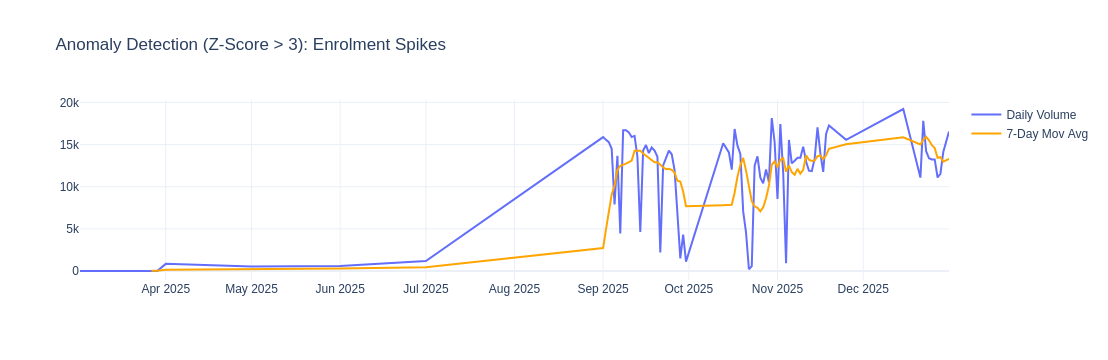

In [10]:
def detect_temporal_anomalies(df, dataset_name, window=7, threshold=3):
    # 1. Aggregate Daily
    daily = df.groupby('date').size().reset_index(name='Count')
    
    # 2. Calculate Rolling Mean & Std Dev
    daily['Rolling_Mean'] = daily['Count'].rolling(window=window).mean()
    daily['Rolling_Std'] = daily['Count'].rolling(window=window).std()
    
    # 3. Define Anomaly Threshold (Mean + 3*Std)
    daily['Upper_Bound'] = daily['Rolling_Mean'] + (threshold * daily['Rolling_Std'])
    daily['Lower_Bound'] = daily['Rolling_Mean'] - (threshold * daily['Rolling_Std'])
    
    # 4. Flag Anomalies
    anomalies = daily[daily['Count'] > daily['Upper_Bound']]
    
    print(f"--- {dataset_name} Anomaly Report ---")
    print(f"Number of Suspicious Spikes Detected: {len(anomalies)}")
    if not anomalies.empty:
        print(anomalies[['date', 'Count', 'Rolling_Mean']].head(5).to_markdown())
    
    # 5. Visual Inspection
    fig = go.Figure()
    
    # Main Line
    fig.add_trace(go.Scatter(x=daily['date'], y=daily['Count'], mode='lines', name='Daily Volume'))
    
    # Rolling Mean
    fig.add_trace(go.Scatter(x=daily['date'], y=daily['Rolling_Mean'], 
                             line=dict(color='orange', width=2), name=f'{window}-Day Mov Avg'))
    
    # Anomalies
    fig.add_trace(go.Scatter(x=anomalies['date'], y=anomalies['Count'], 
                             mode='markers', name='Anomaly (Spike)',
                             marker=dict(color='red', size=10, symbol='x')))
    
    fig.update_layout(title=f"Anomaly Detection (Z-Score > {threshold}): {dataset_name}")
    fig.show()

detect_temporal_anomalies(df_enrolment, "Enrolment Spikes")